### Import libraries and file

In [371]:
import pandas as pd
import csv
import numpy as np
import warnings
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import complete, fcluster
from scipy.cluster.hierarchy import linkage
import seaborn as sns
from kmedoids import kmedoids
from operator import itemgetter, attrgetter, methodcaller
import distutils
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [317]:
#increase width to 100% in Jupyter Notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Files and paths needed to execute functions

In [318]:
apps_permission = 'anpn.csv'

### Function do find the max size of columns

In [319]:
#preprocessing
def get_max_len():
    with open(apps_permission, 'r') as csvfile:
        reader = csv.reader(csvfile)
        num = []
        for i, row in enumerate(reader):
            num.append(len(row))
        m = max(num)
        #print m
        return m
    
print(get_max_len())

11


In [360]:
def read_lines_from_csv(list_of_lines, filename):
    list_lines = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            if i+1 in list_of_lines:
                #Converts list of strings into list of ints --> results = list(map(int, results))
                list_lines.append(list(map(int, row)))
        return list_lines

### Read and show dataset

In [320]:
df = pd.read_csv(apps_permission, header=None, na_values=0, names=range(get_max_len()), low_memory=False)

In [321]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,a1,p1,p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a2,p5,p7,p9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a3,p2,p3,p4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a4,p7,p5,p8,p3,NaN,NaN,NaN,NaN,NaN,NaN
4,a5,p4,p1,p6,p9,p7,p3,NaN,NaN,NaN,NaN


In [322]:
df

,0,1,2,3,4,5,6,7,8,9,10
0,a1,p1,p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a2,p5,p7,p9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a3,p2,p3,p4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a4,p7,p5,p8,p3,NaN,NaN,NaN,NaN,NaN,NaN
4,a5,p4,p1,p6,p9,p7,p3,NaN,NaN,NaN,NaN
5,a6,p7,p3,p5,p2,NaN,NaN,NaN,NaN,NaN,NaN
6,a7,p1,p5,p9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,a8,p6,p3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,a9,p1,p3,p5,p6,p7,p8,p9,NaN,NaN,NaN
9,a10,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10


### Filter Dataset

In [323]:
permissions = set()
permissions_list = set()
apps_list = set()


for index, row in df.iterrows():
    app = row[0]
    
    for perm in row[1:]:
        if str(perm) == 'nan':
            break
        else:
            #perm_list = perm.split('.')
            perm_list = perm
            perm_t = perm_list.lower()
            permissions.add(perm_t)
            permissions_list.add((app, perm_t))
            apps_list.add(app)

### Create new dataframe from filter permissions and apps

In [324]:
df_apps = pd.DataFrame(list(permissions_list))
df_apps.head()
df_apps

,0,1
0,a8,p3
1,a4,p7
2,a5,p9
3,a7,p5
4,a9,p1
5,a10,p5
6,a12,p9
7,a3,p2
8,a4,p8
9,a9,p3


### Create a matrix from dataframe

In [325]:
matrix = pd.crosstab(index=df_apps[0], columns = df_apps[1])

In [346]:
matrix.shape

(12, 10)

In [347]:
map_perm = {idx: c for idx, c in enumerate(matrix.columns)}

In [349]:
array_matrix = np.array(matrix)

In [350]:
array_matrix.shape

(12, 10)

### Calculate similarity matrix (>= 16gb to run)

In [326]:
similarity_matrix = np.float32(squareform(pdist(matrix, 'cosine')))

### Write similarity matrix in file (.npy)

In [327]:
#np.save('sim_matrix_fd1.npy', similarity_matrix)
# or
#np.savetxt("foo_fd1.csv", similarity_matrix, delimiter=",", fmt='%1.8f')

### Delete index and colum name in matrix

In [328]:
del matrix.index.name

In [329]:
del matrix.columns.name

### Verify how index is organized and if needed reindex the matrix rows order

In [330]:
matrix.index

Index(['a1', 'a10', 'a11', 'a12', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8',
       'a9'],
      dtype='object')

In [331]:
matrix.reindex(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8',
                'a9', 'a10', 'a11', 'a12'])

,p1,p10,p2,p3,p4,p5,p6,p7,p8,p9
a1,1,0,1,0,0,0,0,0,0,0
a2,0,0,0,0,0,1,0,1,0,1
a3,0,0,1,1,1,0,0,0,0,0
a4,0,0,0,1,0,1,0,1,1,0
a5,1,0,0,1,1,0,1,1,0,1
a6,0,0,1,1,0,1,0,1,0,0
a7,1,0,0,0,0,1,0,0,0,1
a8,0,0,0,1,0,0,1,0,0,0
a9,1,0,0,1,0,1,1,1,1,1
a10,1,1,1,1,1,1,1,1,1,1


### Transform distance matrix from numpy array to panda dataframe to show it in a better way

In [332]:
matrix_cosine_distance = pd.DataFrame(similarity_matrix)

In [333]:
matrix_cosine_distance

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.552786,1.000000,0.683772,1.000000,0.591752,1.000000,0.711325,0.646447,0.591752,1.000000,0.732739
1,0.552786,0.000000,0.452277,0.292893,0.452277,0.452277,0.367544,0.225403,0.367544,0.452277,0.552786,0.163340
2,1.000000,0.452277,0.000000,1.000000,0.666667,1.000000,0.422650,1.000000,0.711325,0.666667,1.000000,0.563564
3,0.683772,0.292893,1.000000,0.000000,0.483602,0.483602,0.552786,0.087129,0.552786,0.483602,0.683772,0.323877
4,1.000000,0.452277,0.666667,0.483602,0.000000,1.000000,0.422650,0.528596,0.422650,0.333333,1.000000,0.345346
5,0.591752,0.452277,1.000000,0.483602,1.000000,0.000000,0.711325,0.528596,0.422650,1.000000,0.591752,0.781782
6,1.000000,0.367544,0.422650,0.552786,0.422650,0.711325,0.000000,0.591752,0.250000,0.711325,0.646447,0.244071
7,0.711325,0.225403,1.000000,0.087129,0.528596,0.528596,0.591752,0.000000,0.591752,0.528596,0.422650,0.228483
8,0.646447,0.367544,0.711325,0.552786,0.422650,0.422650,0.250000,0.591752,0.000000,0.711325,0.646447,0.433053
9,0.591752,0.452277,0.666667,0.483602,0.333333,1.000000,0.711325,0.528596,0.711325,0.000000,1.000000,0.345346


### Execute kmedoid from 2 to 4 clusters

In [334]:
medoid={}
cluster={}
for i in range(2,6):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sm, c = kmedoids(similarity_matrix, k=i)
        medoid[i] = sm
        cluster[i] = c

### Save medoids and clusters in a npy files

In [335]:
#np.save('sample_model_12x10_medoid.npy', medoid)

In [336]:
#np.save('sample_model_12x10_cluster.npy', cluster)

### Load the npy files that were saved

In [337]:
#dt_clusters = np.load('/mnt/googleplay-api/sample_model_12x10_cluster.npy',allow_pickle=True).tolist()

### Create csv files that each one represents a cluster

In [338]:
dt_clusters = cluster

In [339]:
for n, x in enumerate(dt_clusters.keys()):
    dt = dt_clusters[x]
    
    dt1 = [key for key, list_values in dt.items() for cluster in list_values]
    dt2 = [item_id for key, list_values in dt.items() for item_id in list_values]

    dt3 = sorted(list(zip(dt2, dt1)), key=lambda x: x[0])

    file2write = '/mnt/csv-files/sample_model/12x10/i2csv_cluster_{}_12x10.csv'.format(n)

    with open(file2write, 'w') as ifw:
        for item_id, cluster in dt3:
            ifw.write("{}\t{}\n".format(item_id, cluster))

### Using csv files to create intersection between partitions named "Consensus Groups"

In [345]:
merged = pd.DataFrame()
clustersData = pd.DataFrame(columns=["ID", "cLabel", "pLabel"]) #pd.DataFrame(columns=["cID", "cLabel", "pLabel", "cSize"])

#Directory where cluster files was stored
dirPartitions = '/mnt/csv-files/sample_model/12x10'

(head, tail) = os.path.split(dirPartitions)
print('head: '+head)
print('tail: ' + tail)
expDirName = tail + '-files'
print('expDirName: '+expDirName)

resDir = head + '/' + expDirName # os.path.join(head, expDirName);
print(resDir)

if not os.path.exists(resDir):
    os.makedirs(resDir)

allClustersLabels = []
for filename in os.listdir(dirPartitions):
    file =  dirPartitions + '/' + filename
    p = pd.read_csv(file, sep='\t', header=None)
    p.columns = ["ID", "clusterLabel"]
    allClusters = set(p["clusterLabel"])
    for cluster in allClusters:
        cLabel = "c"+str(cluster)
        newCluster = cLabel+filename
        allClustersLabels.insert(len(allClustersLabels), newCluster)
        p[newCluster] = (p["clusterLabel"] == cluster).astype(int) # column with cluster membership (1/0)
        clustersData = clustersData.append({"ID": newCluster, "cLabel": cLabel, "pLabel": filename, "cSize": p[newCluster].sum()}, ignore_index=True)

    del p["clusterLabel"]

    if merged.empty:
        merged = pd.DataFrame(p)
    else:
        merged = merged.merge(p, how="outer", on="ID")

distinct = {}
dist2 = merged.groupby(allClustersLabels, sort=False)
file = resDir + '/listsIdenticalObjs.tsv'
file_txt = resDir + '/listsIdenticalObjs.txt'
print(file)
with open(file, 'w') as f:
    out = csv.writer(f, delimiter='\t', lineterminator='\n')
    # identify the objects identically grouped in all clusters
    for name, group in dist2:
        values = group["ID"].values
        distinct[values[0]] = values
        out.writerow(values)
print(file_txt)
with open(file_txt, 'w') as f:
    out = csv.writer(f, delimiter=',', lineterminator='\n')
    # identify the objects identically grouped in all clusters
    for name, group in dist2:
        values = group["ID"].values
        distinct[values[0]] = values
        out.writerow(values)
repeatedObjs = merged.loc[~merged["ID"].isin(distinct.keys())]["ID"].index
# save the lists of identically grouped objects

merged.drop(repeatedObjs,inplace=True)

objectsIDs = merged["ID"]

clustersData = clustersData.set_index(["ID"])
merged = merged.set_index(["ID"])

mergedT = merged.transpose()

# identifies the distinct clusters
distinctClusters = mergedT.drop_duplicates().index
print(distinctClusters)

file = resDir + '/listDistinctClusters.tsv'
with open(file, 'w') as f:
    out = csv.writer(f, delimiter='\t', lineterminator='\n')
    out.writerow([k for k in distinctClusters])

complete = mergedT.join(clustersData)
complete.sort_values(by=["cSize"], ascending=False, inplace=True)

file = resDir + '/result.tsv'
complete.to_csv(file ,sep='\t', index_label = "ID")

eacM = {}
for o1 in objectsIDs:
    eacM[o1] = complete.loc[complete[o1]==1]["cSize"].sum()

x = sorted(eacM.items(), key=itemgetter(1), reverse=True)
print(x)
file = os.path.join(resDir, 'objOrderEAC.tsv')
file = resDir + '/objOrderEAC.tsv'
with open(file, 'w') as f:
    out = csv.writer(f, delimiter='\t', lineterminator='\n')
    out.writerow([k for (k,v) in x])

head: /mnt/csv-files/sample_model
tail: 12x10
expDirName: 12x10-files
/mnt/csv-files/sample_model/12x10-files
/mnt/csv-files/sample_model/12x10-files/listsIdenticalObjs.tsv
/mnt/csv-files/sample_model/12x10-files/listsIdenticalObjs.txt
Index(['c0i2csv_cluster_2_12x10.csv', 'c1i2csv_cluster_2_12x10.csv',
       'c2i2csv_cluster_2_12x10.csv', 'c3i2csv_cluster_2_12x10.csv',
       'c1i2csv_cluster_3_12x10.csv', 'c2i2csv_cluster_3_12x10.csv',
       'c3i2csv_cluster_3_12x10.csv', 'c4i2csv_cluster_3_12x10.csv',
       'c1i2csv_cluster_0_12x10.csv', 'c0i2csv_cluster_1_12x10.csv',
       'c1i2csv_cluster_1_12x10.csv', 'c2i2csv_cluster_1_12x10.csv'],
      dtype='object')
[(1, 30.0), (3, 23.0), (7, 23.0), (0, 22.0), (2, 21.0), (5, 21.0), (10, 20.0), (4, 16.0)]


### Count similar objects

In [341]:
file_to_read = open("/mnt/csv-files/sample_model/12x10-files/listsIdenticalObjs.tsv", "r")
file_to_write = open("/mnt/csv-files/sample_model/12x10-files/Counted_apps_per_line.csv", "w")
line_counter = 0
for line in file_to_read:
	line_counter += 1
	count = line.count('\t')
	content_to_write = str(line_counter)+","+str(count + 1)+"\n"
	file_to_write.write(content_to_write)
# print(line_counter,",",+(count  + 1))
file_to_read.close()
file_to_write.close()

In [342]:
clustered_apps_per_line = '/mnt/csv-files/sample_model/12x10-files/Counted_apps_per_line.csv'

In [355]:
df_statistics = pd.read_csv(clustered_apps_per_line, header=None, names=['line','QtyApps'])

In [356]:
df_statistics

,line,QtyApps
0,1,1
1,2,4
2,3,1
3,4,1
4,5,2
5,6,1
6,7,1
7,8,1


In [351]:
identical_objects = '/mnt/csv-files/sample_model/12x10-files/listsIdenticalObjs.txt'

In [408]:
MIN_APPS = 2
MAX_APPS = 4
MAX_GRAPH_WIDTH = 10
MAX_GRAPH_HEIGHT = 5
GROUP_NAME = 'SAMPLE_MODEL_'

In [398]:
select_df_statistics_by_qty_apps = df_statistics[(df_statistics['QtyApps']>=MIN_APPS) & (df_statistics['QtyApps']<=MAX_APPS)].sort_values(by=['line'])

In [399]:
list_of_lines_by_qty_apps = list(select_df_statistics_by_qty_apps['line'])

In [400]:
list_of_all_worthy_identical_objects = read_lines_from_csv(list_of_lines_by_qty_apps, identical_objects)

In [401]:
graph_qty = len(list_of_all_worthy_identical_objects)

In [402]:
graph_qty

2

### Starts the dynamic part of the algorithm the works like a huge function

In [403]:
def generate_sliced_matrix(list_of_clusters):
    sliced_matrix = []
    for i, cluster_i in enumerate(list_of_clusters):
        row_idx = np.array(cluster_i)
        matrix_sliced = array_matrix[row_idx, :]
        sliced_matrix.append(matrix_sliced)
    return sliced_matrix

### Variables needed to plot graphs

In [404]:
#Set variable to plot graphics
sliced_matrix = generate_sliced_matrix(list_of_all_worthy_identical_objects)
danger_permissions_idx = [2,4,8]
danger_permissions_idx_weight = [50,60,10]
#Defines how many times a permission must be considered in the graph
threshold_percentage = 0.4

### Analysis each group graph and made an energy weight heatmap

In [405]:
for i in range(graph_qty):
    ar_mean = np.mean(sliced_matrix[i][:,danger_permissions_idx],0)
    ar_filtered = np.where(ar_mean<threshold_percentage, 0, 1)
    result = ar_filtered*danger_permissions_idx_weight
    if i == 0:
        group_array = result
    else:
        group_array = np.vstack([group_array, result])
sum_rows = np.sum(group_array, axis=1)
xpto = sum_rows.reshape(np.size(sum_rows),1)

#set x axis to Energy analysis graph
x_axis = [map_perm[idx] for idx in danger_permissions_idx]

#set x axis to Permission graph
xticks = [map_perm[idx] for idx in map_perm]

### Energy Analysis Graph

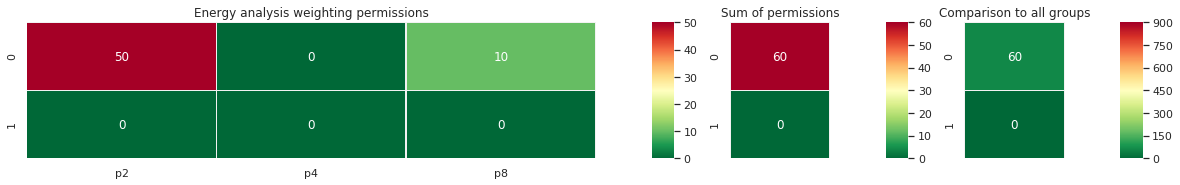

In [411]:
fig = plt.figure(figsize=(20,2.5))
#grid size
gs = gridspec.GridSpec(1, 15, wspace=2.5, hspace=0.8)
#define axis
ax1 = plt.subplot(gs[0, :-7])
ax_bar1 = plt.subplot(gs[0, -7:-6])
ax2 = plt.subplot(gs[0,-6:-4])
ax_bar2 = plt.subplot(gs[0, -4:-3])
ax3 = plt.subplot(gs[0,-3:-1])
ax_bar3 = plt.subplot(gs[0, -1])
#set axis' title
ax1.set_title("Energy analysis weighting permissions")
ax2.set_title("Sum of permissions")
ax3.set_title("Comparison to all groups")
#drawing graphs
im1 = sns.heatmap(group_array, xticklabels = x_axis, annot=True, fmt="d", cmap="RdYlGn_r", linewidths=.5, linecolor="#F2F2F2", ax=ax1, cbar_ax=ax_bar1)
im2 = sns.heatmap(xpto, annot=True, xticklabels=False, fmt="d", cmap="RdYlGn_r", linewidths=.5, linecolor="#F2F2F2", ax=ax2,  cbar_ax=ax_bar2)
im3 = sns.heatmap(xpto, annot=True, xticklabels=False, fmt="d", cmap="RdYlGn_r", linewidths=.5, linecolor="#F2F2F2", ax=ax3, vmin=0, vmax=900, cbar_ax=ax_bar3)
#plt.show()
#Save figure on jupyter-notebook
# fig_name_png = "pictures/" + notebookName + "_energy_analysis.png"
# plt.savefig(fig_name_png, transparent=False)
# fig_name_pdf = "pictures/" + notebookName + "_energy_analysis.pdf"
# plt.savefig(fig_name_pdf)

### Permission Analysis Graph

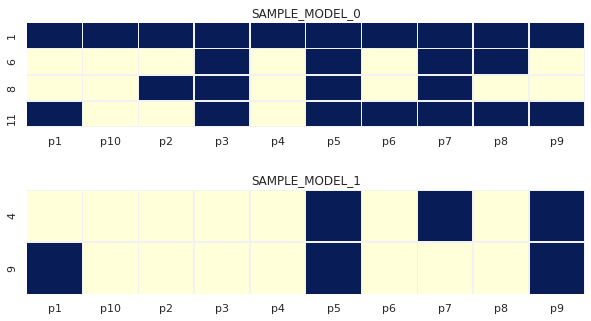

In [409]:
#fig, axs = plt.subplots(nrows=10, ncols=4)
sns.set(font_scale=1)
fig, axs = plt.subplots(graph_qty, 1, figsize=(MAX_GRAPH_WIDTH, MAX_GRAPH_HEIGHT))
plt.subplots_adjust(hspace=0.6)
for i in range(graph_qty):
        axs[i].set_title(GROUP_NAME + str(i))
        sns.heatmap(sliced_matrix[i], xticklabels = xticks, cbar = False, square=False, yticklabels = list_of_all_worthy_identical_objects[i], cmap="YlGnBu", linewidths=.5, linecolor="#F2F2F2", ax=axs[i])
#Save figure on jupyter-notebook
# fig_name_png = "pictures/" + notebookName + "_background.png"
# plt.savefig(fig_name_png, transparent=False)
# fig_name_pdf = "pictures/" + notebookName + "_background.pdf"
# plt.savefig(fig_name_pdf)